# Nowcasting Economic Data

## Introduction

Nowcasting is a methodology, borrowed from meteorology, used in macroeconomics to forecast the recent past, current state and the near future of the state of the economy. The data describing the the state is typically incomplete, heterogenous and delayed. For example

>euro-area gross domestic product (GDP) is only available on a quarterly ba­ sis and is released 6 weeks after the close of the quarter. In March 2010, for instance, we only had information up to the last quarter of 2009 and needed to wait until mid-May to obtain a first estimate of the first quarter of 2010. However, there are several variables, available at monthly frequency and published with shorter delay, that can be used to con­ struct early estimates of GDP. 

Nowcasting is a methodology, borrowed from meteorology, used in economics to forecast the "current" state of a high-dimensional dynamic system. The data describing the current state is typically incomplete, heterogenous and delayed. For example, data that make up GDP are published at differing frequencies and at different times, resulting in a lag in publishing of GDP. At any given time $t$ and given available data as of $t$, we would like to guess the unknown data. 

Nowcasting approaches in economics typically impose a lot of restrictions on the data e.g a factor structure to reduce dimensionality of data, a probability model e.g. $AR(1)$ with innovations in factors are iid Gaussian, etc. 

## Nowcasting using Matrix Completion

Matrix completion might offer an alternative approach to the problem that does not impose restrictive structure. I use Beber et al (2015) as an example. This paper considers four different sets of thematic data: inflation, employment, output and sentiment. 

In [2]:
using LinearAlgebra, Random, Plots, CSV, DataFrames, TimeSeries, Dates

"/users/balaji/research/projects/nowcast/"

Two helper functions to implement Soft-impute ALS of @hastie2015matrix.

In [2]:
function proj(X, Ω)
    Z = deepcopy(X)
    Z[Ω] .= 0.0
    return Z
end

proj (generic function with 1 method)

In [1]:
function als(X; λ = 1.0, tol = 1e-4, maxiter = 1000)
    Y = deepcopy(X)
    m,n = size(Y)
    Ω, Ψ = findall(isnan, Y), findall(!isnan,Y)
    r = min(m,n)
    A, B = randn(m, r), randn(n, r)
    C = fill(0., m, n)
    iter = 0
    while true
        C .= A * B'
        Y .= proj(X, Ω) + proj(C, Ψ)
        A .= Y * B * inv(B' * B + λ * I)
        Y .= proj(X, Ω) + proj(A * B', Ψ)
        B .= Y' * A * inv(A' * A + λ * I)
        δ = norm(A * B' - C, 2) / norm(C, 2)
        if δ < tol || iter > maxiter   
            break
        end
        iter += 1
    end
    return A, B
end

als (generic function with 1 method)

In [4]:
function mse(X, Y, Ω)
    err = norm(proj(X, Ω) - proj(Y, Ω), 2)/length(Ω)
    return err
end

mse (generic function with 1 method)

In [ ]:
function createTestMatrix(m::Integer, n::Integer; frac=0.1)
    A = randn(m, n)
    Ω = rand(CartesianIndices((1:m, 1:n)), floor(Int, m * n * frac))
    A[Ω] .= NaN
    return A
end

## Inflation

Let's import inflation data. The non-synchronous nature of data is apparent.

In [5]:
df = DataFrame(CSV.File("inflation_cleaned.csv", dateformat = "yyyy-mm-dd"))
last(df, 5)

,timestamp,imp1chng,ppichng,pxfechng,cpichng,cpupxchng,gdppiqq,pcecmom,prodnfr%
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2021-01-28,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
2,2021-01-29,NaN,NaN,NaN,NaN,NaN,NaN,0.3,NaN
3,2021-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.8
4,2021-02-10,NaN,NaN,NaN,0.3,0.0,NaN,NaN,NaN
5,2021-02-18,1.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Remove rows that have all values missing. In other words, only those time points where at least one variable is observed or published are considered.

In [6]:
m = ncol(df) - 1
f(x) = (sum(isnan.(Array(x)[2:end])) != m)
filter!(f, df)
nothing

Convert the data into matrix form, discarding the time index. $\Omega$ is the set of all indices at which data are missing.

In [7]:
A = Array(df[:, Not(:timestamp)])
Ω = findall(isnan, A)
A[end-5:end, :]

6×9 Array{Float64,2}:
   0.9  NaN  NaN  NaN    NaN    NaN    NaN    NaN    NaN
 NaN    NaN  NaN  NaN    NaN      2.0  NaN    NaN    NaN
 NaN    NaN  NaN  NaN    NaN    NaN      0.3  NaN    NaN
 NaN    NaN  NaN  NaN    NaN    NaN    NaN     -4.8  NaN
 NaN    NaN  NaN    0.3    0.0  NaN    NaN    NaN    NaN
   1.4  NaN  NaN  NaN    NaN    NaN    NaN    NaN    NaN

Run Soft-impute ALS for different values of penalty term and see how the error changes as a function of penalty.

In [8]:
λ = [0.01, 0.1, 1., 10, 20, 30, 50]
err = fill(0., length(λ))
for (iter, val) in enumerate(λ)
        a, b = als(A, λ = val)
        C = a*b'
        err[iter] = mse(A, C, Ω)
end

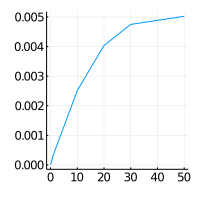

In [9]:
plot(λ, err, leg=false, size = (200,200))

Let's see how the nowcasting worked for different variables, starting with cpichng. First, a helper function to plot the comparison for a given year.

In [10]:
function plotNowcast(variable, timeperiod; λ = [0.05, 0.1, 1., 5., 10.], legloc = :best)
    original = df[:, [:timestamp, variable]]
    original = original[isnan.(original[:, variable]) .== false, :]
    original = TimeArray(original, timestamp = :timestamp)
    idx = findfirst(isequal(string(variable)), names(df)[2:end])
    p = scatter(original[timeperiod], label = "original", title = string(variable), 
        leg = legloc)
    for l in λ
            a, b = als(A, λ = l)
            c = a*b'
            completed = TimeArray(df.timestamp, c[:, idx])
            plot!(p, completed[timeperiod], label = "nowcast λ = $(l)")
    end
    return p
end

plotNowcast (generic function with 1 method)

### CPICHNG

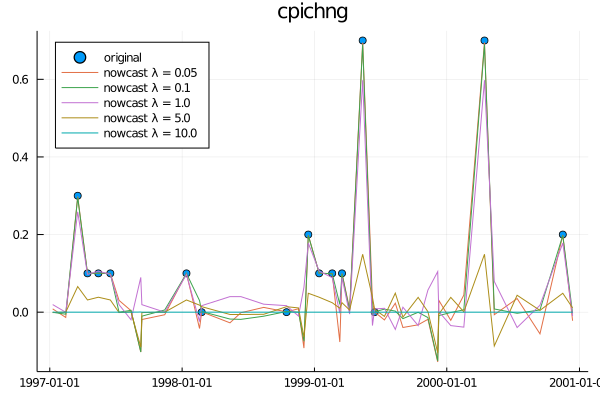

In [11]:
variable = :cpichng
timeperiod = Date(1990,1,1):Day(3):Date(2000,12,31)
plotNowcast(variable, timeperiod, legloc = :topleft)

### PPICHNG

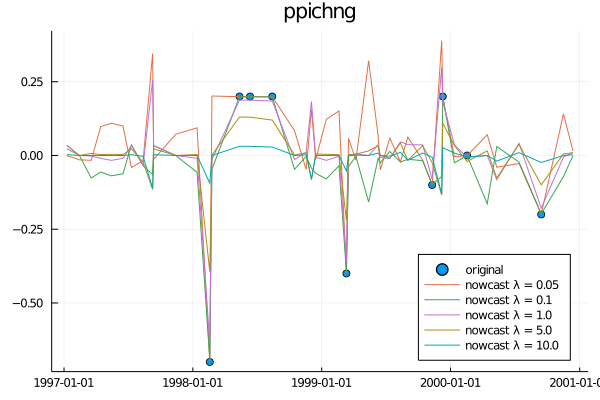

In [12]:
variable = :ppichng
timeperiod = Date(1990,1,1):Day(3):Date(2000,12,31)
plotNowcast(variable, timeperiod, legloc = :bottomright)

### CPUPXCHNG

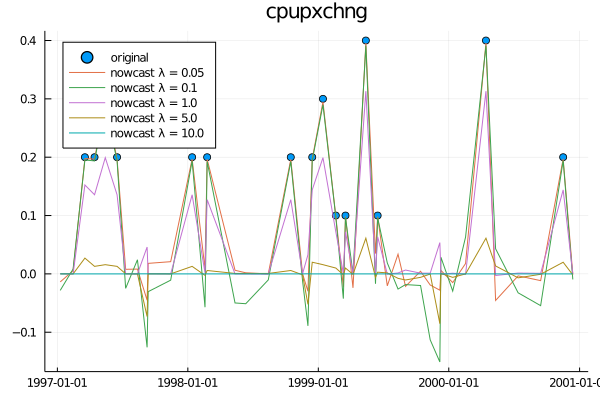

In [13]:
variable = :cpupxchng
timeperiod = Date(1990,1,1):Day(3):Date(2000,12,31)
plotNowcast(variable, timeperiod, legloc = :topleft)

### PXFECHNG

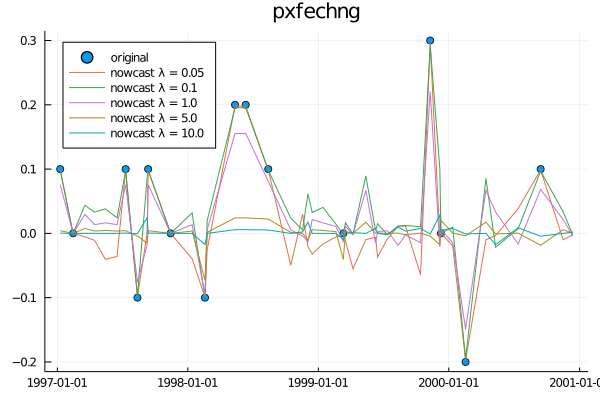

In [14]:
variable = :pxfechng
timeperiod = Date(1990,1,1):Day(3):Date(2000,12,31)
plotNowcast(variable, timeperiod, legloc = :topleft)

### GDPPIQQ

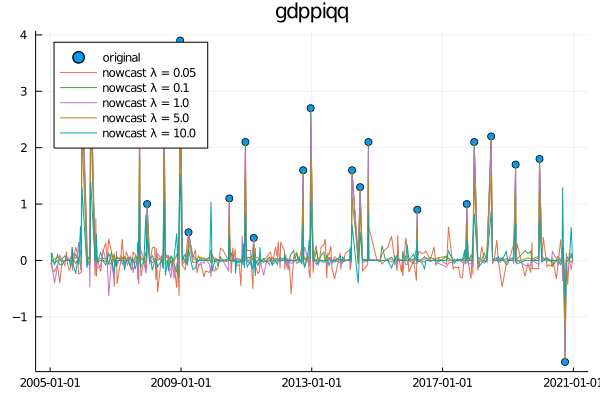

In [15]:
variable = :gdppiqq
timeperiod = Date(2005,1,1):Day(3):Date(2020,12,31)
plotNowcast(variable, timeperiod, legloc = :topleft)